In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('default')

import seaborn as sns
import datetime

from warnings import filterwarnings
filterwarnings("ignore")

In [2]:
esolatDF = pd.read_csv("DW_prayer_times.csv")

esolatDF = esolatDF[
    ["date","esolat_fajr","esolat_zuhr","esolat_asr","esolat_maghrib","esolat_isha"]
]
esolatDF["date"] = pd.to_datetime(esolatDF["date"]).dt.date

esolatDF

,date,esolat_fajr,esolat_zuhr,esolat_asr,esolat_maghrib,esolat_isha
0,2018-01-01,358,799,1002,1156,1230
1,2018-01-02,358,800,1002,1156,1231
2,2018-01-03,359,800,1003,1157,1231
3,2018-01-04,359,801,1003,1157,1232
4,2018-01-05,360,801,1004,1158,1232
...,...,...,...,...,...,...
2917,2025-12-27,364,797,1000,1154,1229
2918,2025-12-28,364,798,1000,1155,1229
2919,2025-12-29,365,798,1001,1155,1230
2920,2025-12-30,365,799,1001,1156,1230


<h2>Time Series Plots</h2>

In [3]:
def plot_time_series():
	f, ax = plt.subplots(nrows=5, ncols=1, sharex=True, figsize=(20,12))
	f.suptitle("Time series of prayer times (Source: e-Solat JAKIM) in 2018-2025, total minutes", fontsize=15)

	esolatDF.plot(x="date", y="esolat_fajr", kind="line", ax=ax[0], linewidth=1, color="C0")
	esolatDF.plot(x="date", y="esolat_zuhr", kind="line", ax=ax[1], linewidth=1, color="C1")
	esolatDF.plot(x="date", y="esolat_asr", kind="line", ax=ax[2], linewidth=1, color="C2")
	esolatDF.plot(x="date", y="esolat_maghrib", kind="line", ax=ax[3], linewidth=1, color="C3")
	esolatDF.plot(x="date", y="esolat_isha", kind="line", ax=ax[4], linewidth=1, color="C4")

	for i in range(5):
		ax[i].set_ylabel("Total Minutes")

	ax[4].set_xlabel("Date/Year")
	plt.show()

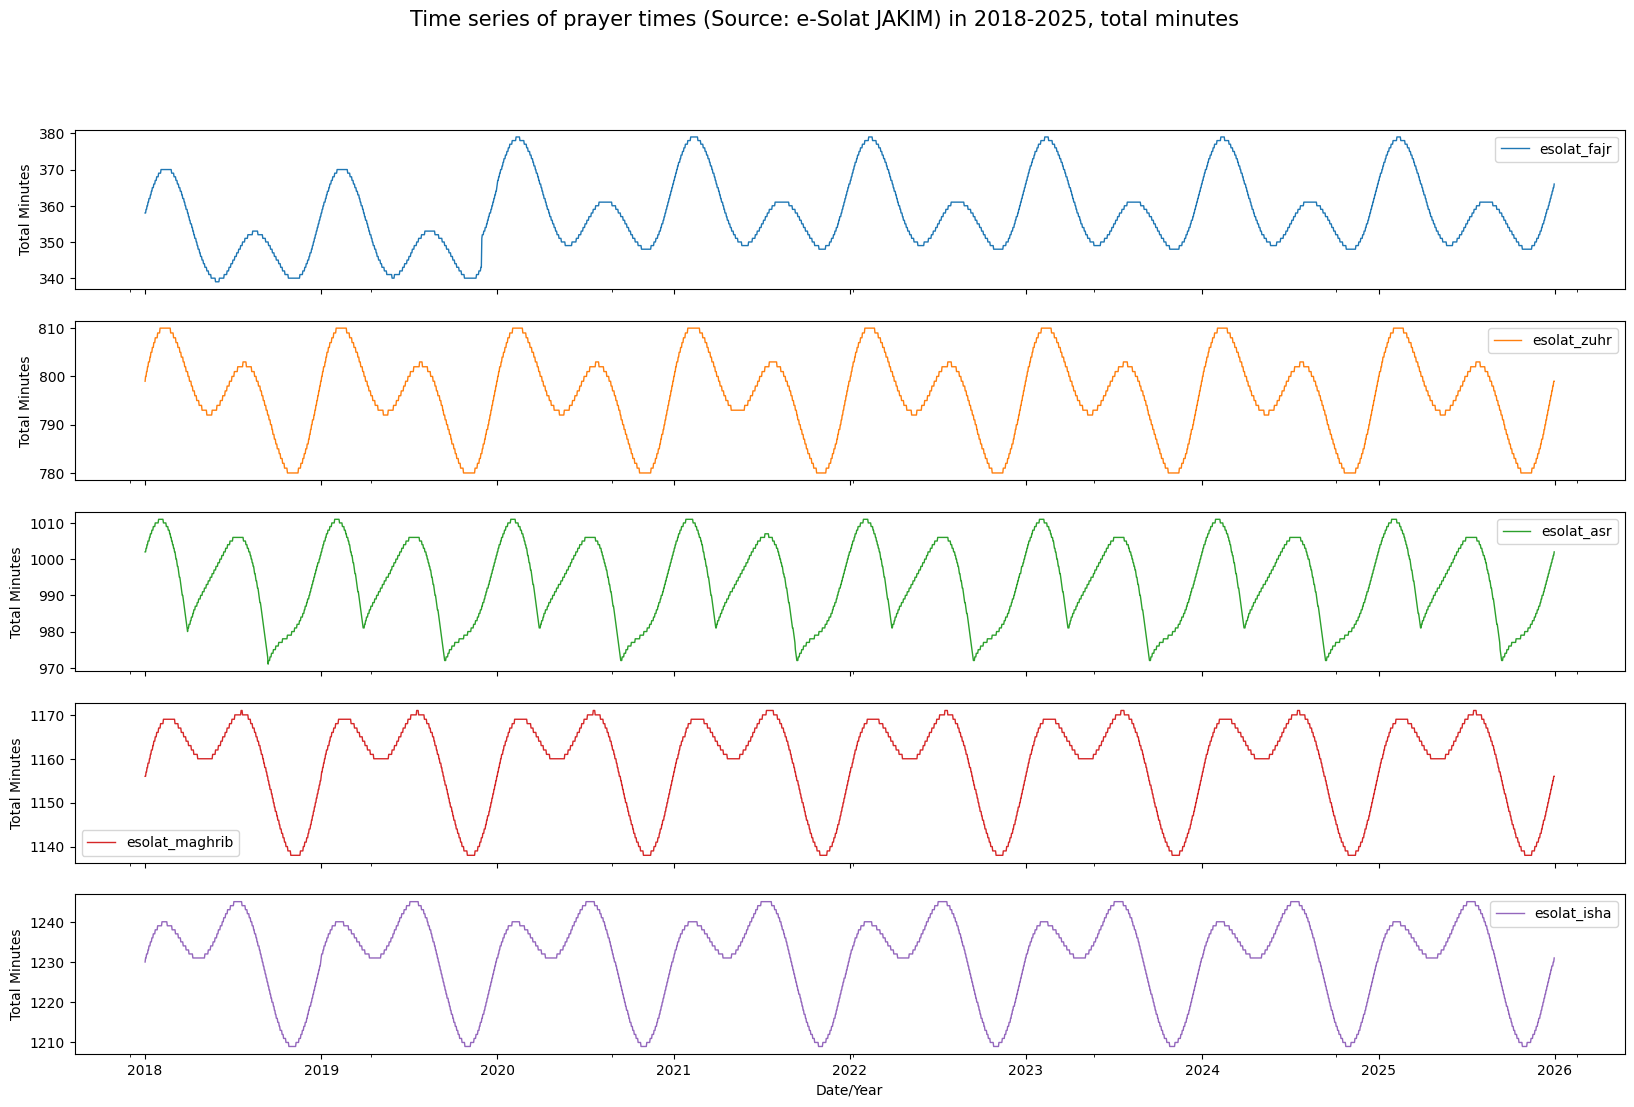

In [4]:
plot_time_series()

In [5]:
esolatDF["esolat_fajr"] = np.where(\
    esolatDF["date"] < datetime.date(2019, 11, 30),\
    esolatDF["esolat_fajr"] + 8,\
    esolatDF["esolat_fajr"]\
)

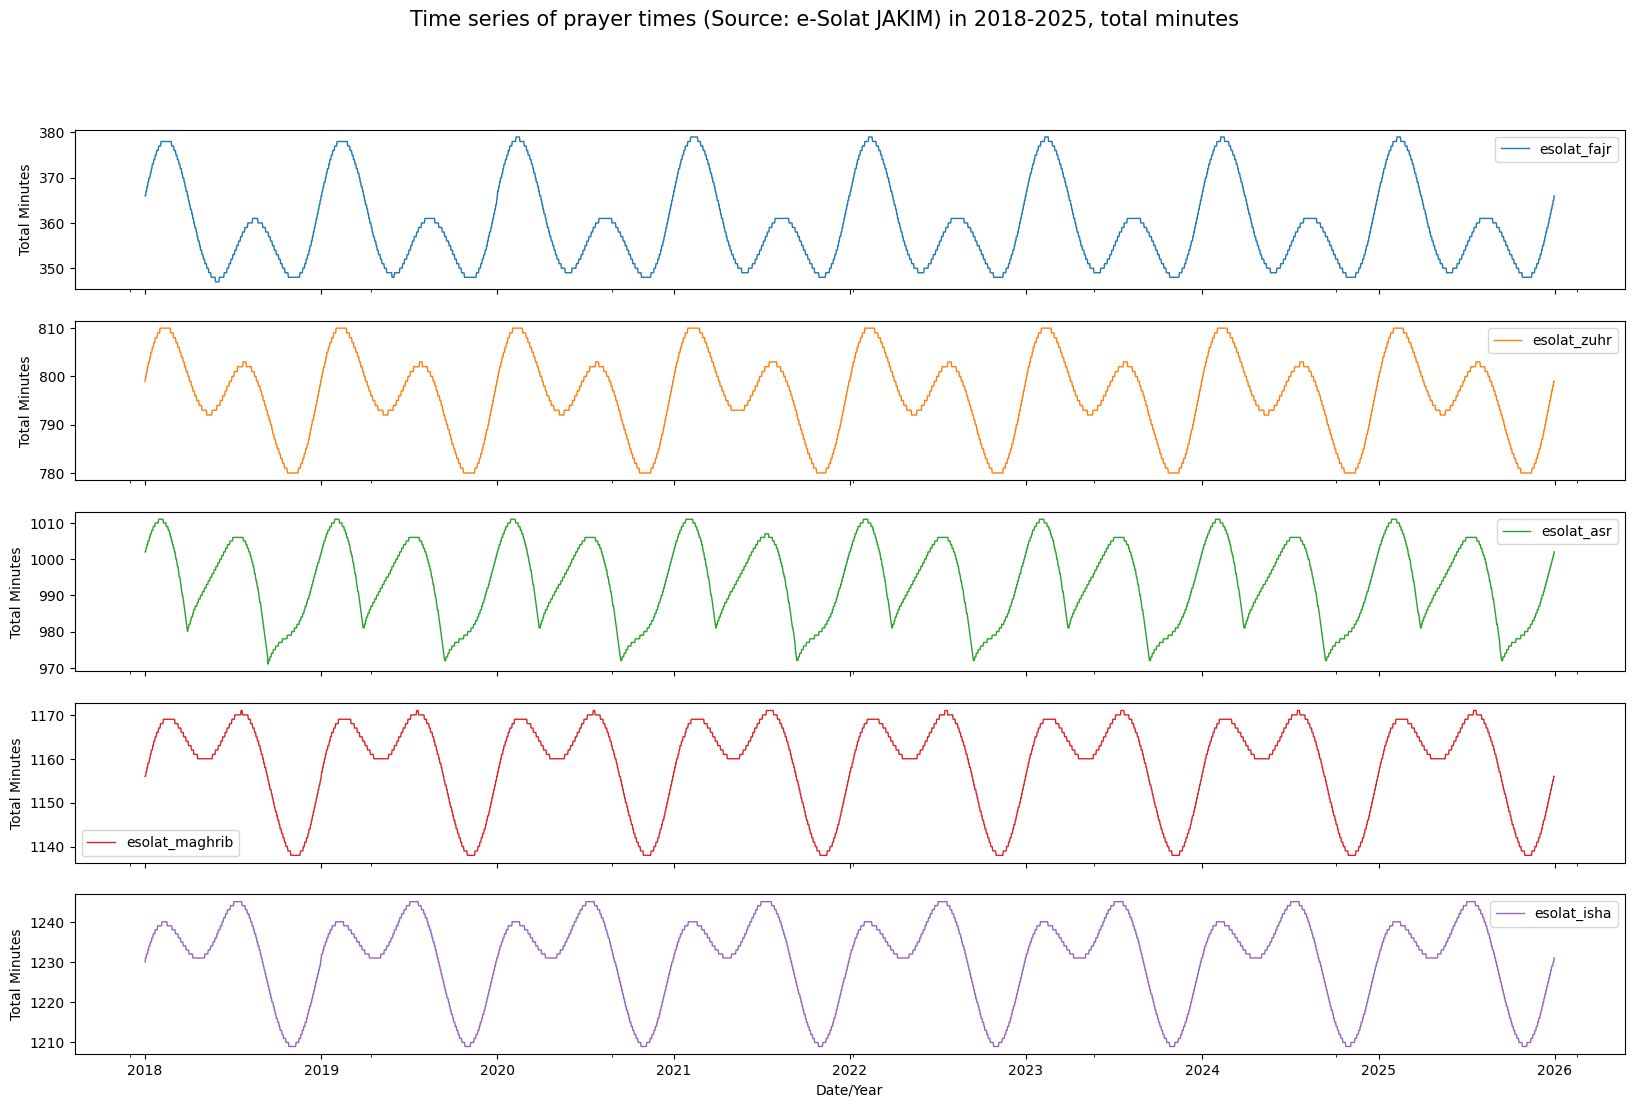

In [6]:
plot_time_series()

<h2>Time Series Decomposition Charts</h2>

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [8]:
# Time Series Decomposition Charts
def decompose_time_series_charts(col_name=""):
    if col_name not in esolatDF.columns:
        return
    
    decomp = seasonal_decompose(esolatDF[col_name], period=365, model="additive", extrapolate_trend="freq")

    f, ax = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(20,12))
    f.suptitle(f"Decomposition of {col_name}", fontsize=15)
    
    decomp.observed.plot(ax=ax[0], legend=False, color="C0", linewidth=1)
    ax[0].set_ylabel("Observed/Actual")

    decomp.trend.plot(ax=ax[1], legend=False, color="C1", linewidth=1)
    ax[1].set_ylabel("Trend")

    decomp.seasonal.plot(ax=ax[2], legend=False, color="C2", linewidth=1)
    ax[2].set_ylabel("Seasonal")

    decomp.resid.plot(ax=ax[3], legend=False, color="C3", linewidth=1)
    ax[3].set_ylabel("Residual/Noise")

    plt.xticks()
    ax[3].set_xlabel("Time Progress")
    plt.show()

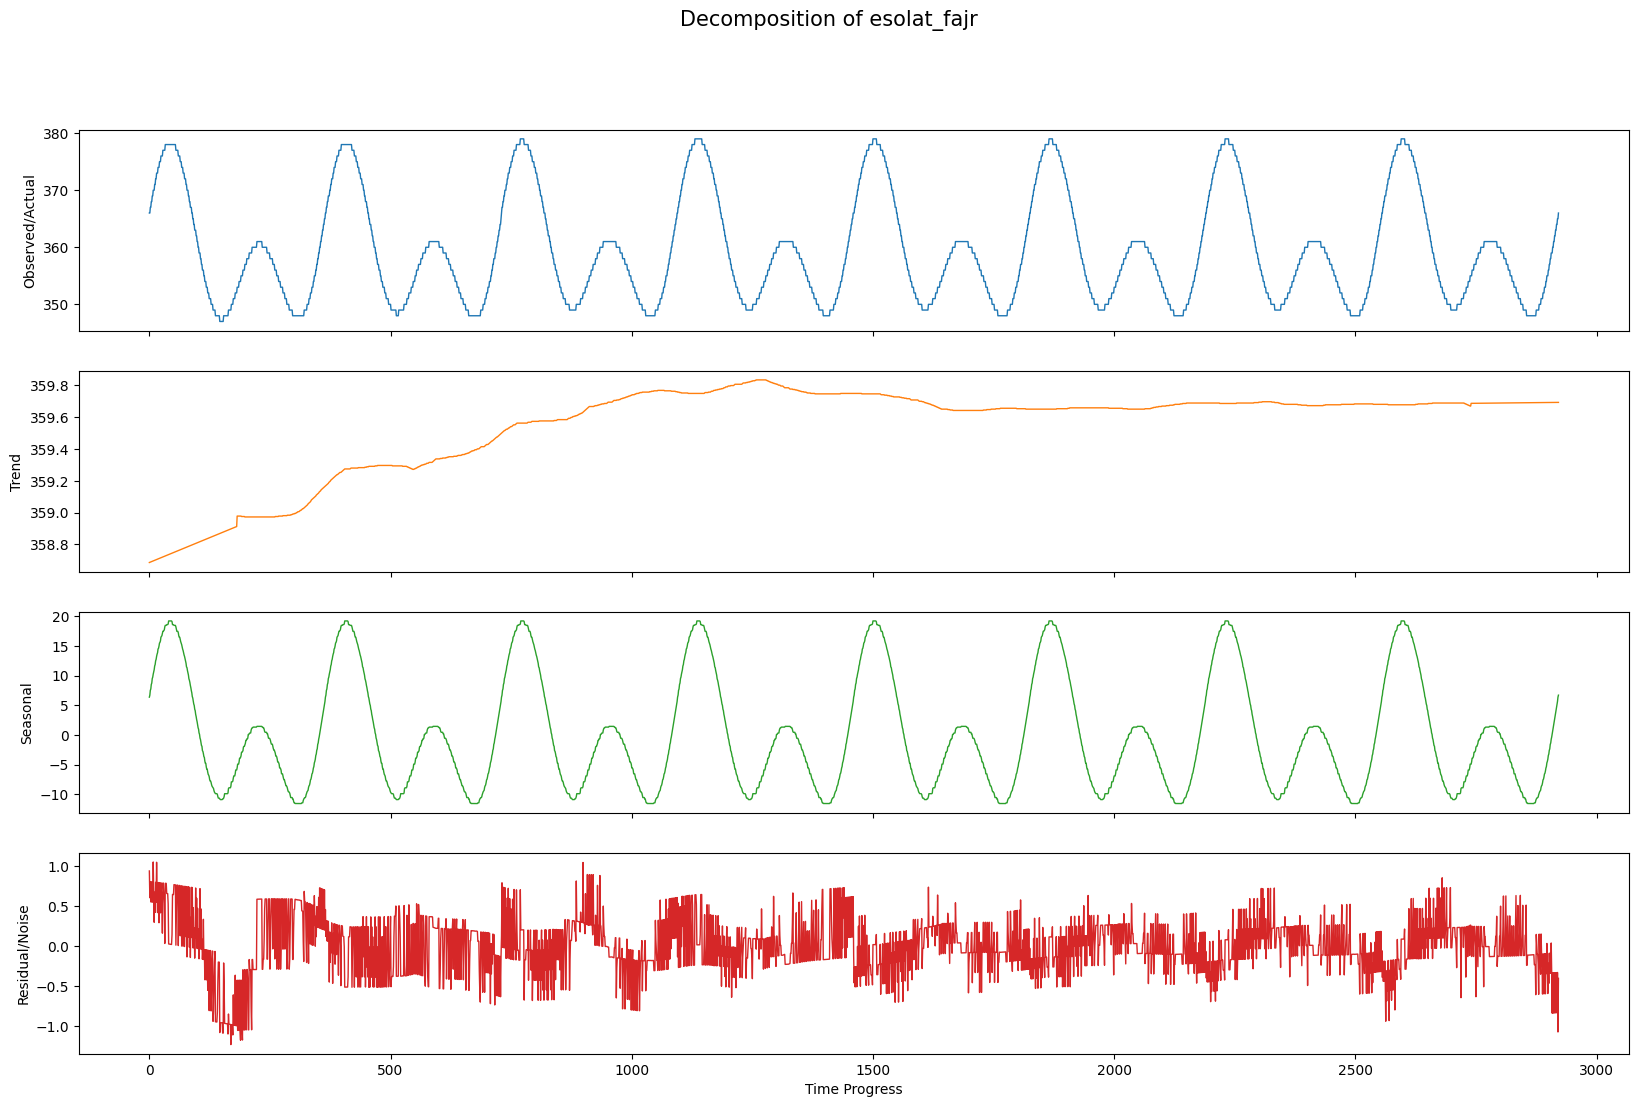

In [9]:
decompose_time_series_charts("esolat_fajr")

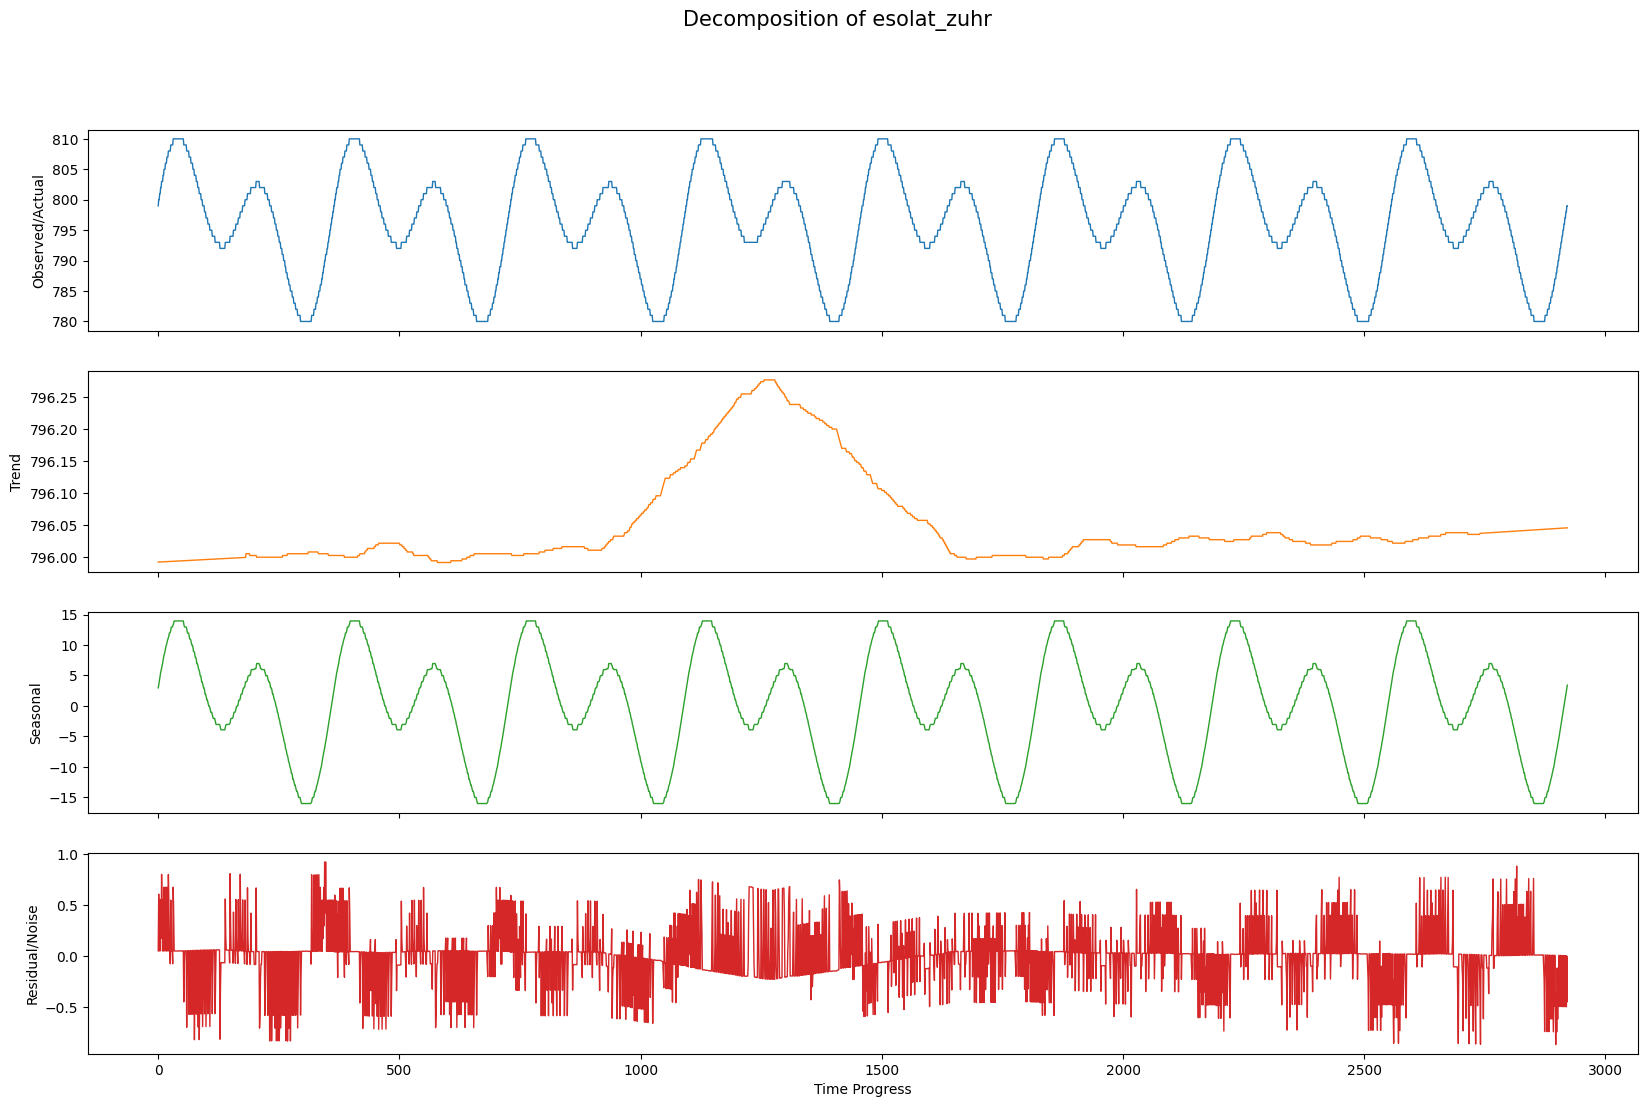

In [10]:
decompose_time_series_charts("esolat_zuhr")

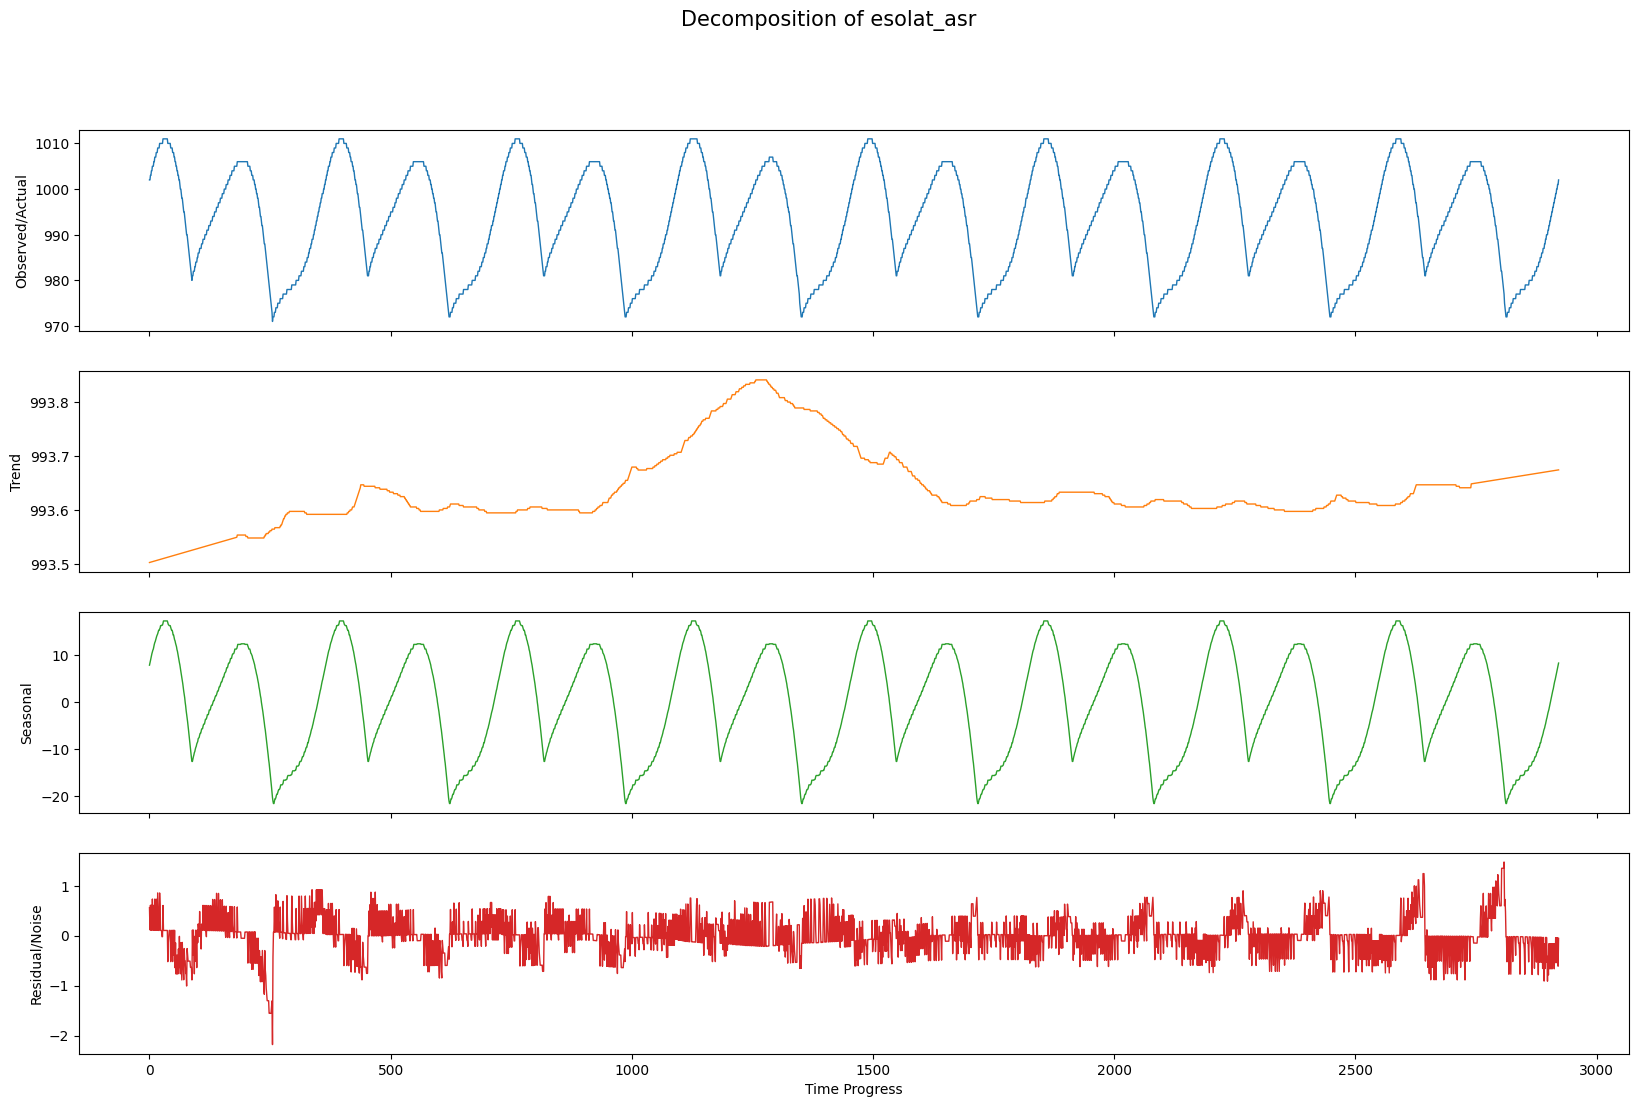

In [11]:
decompose_time_series_charts("esolat_asr")

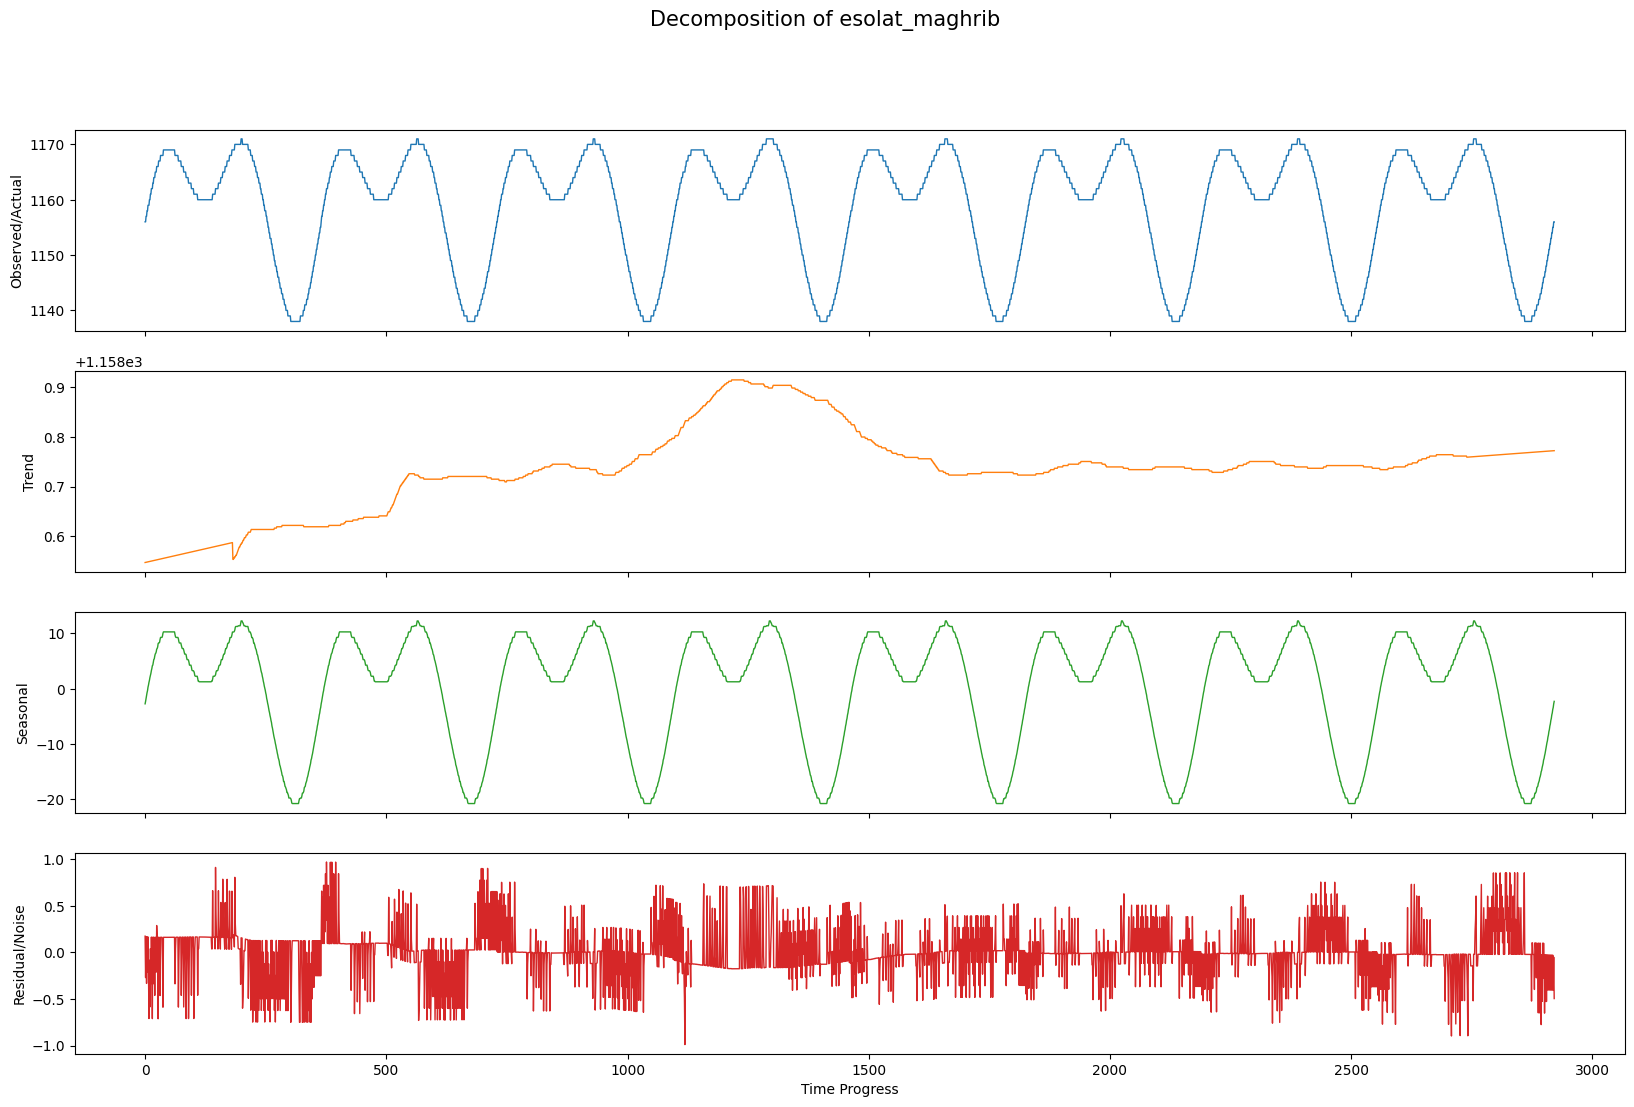

In [12]:
decompose_time_series_charts("esolat_maghrib")

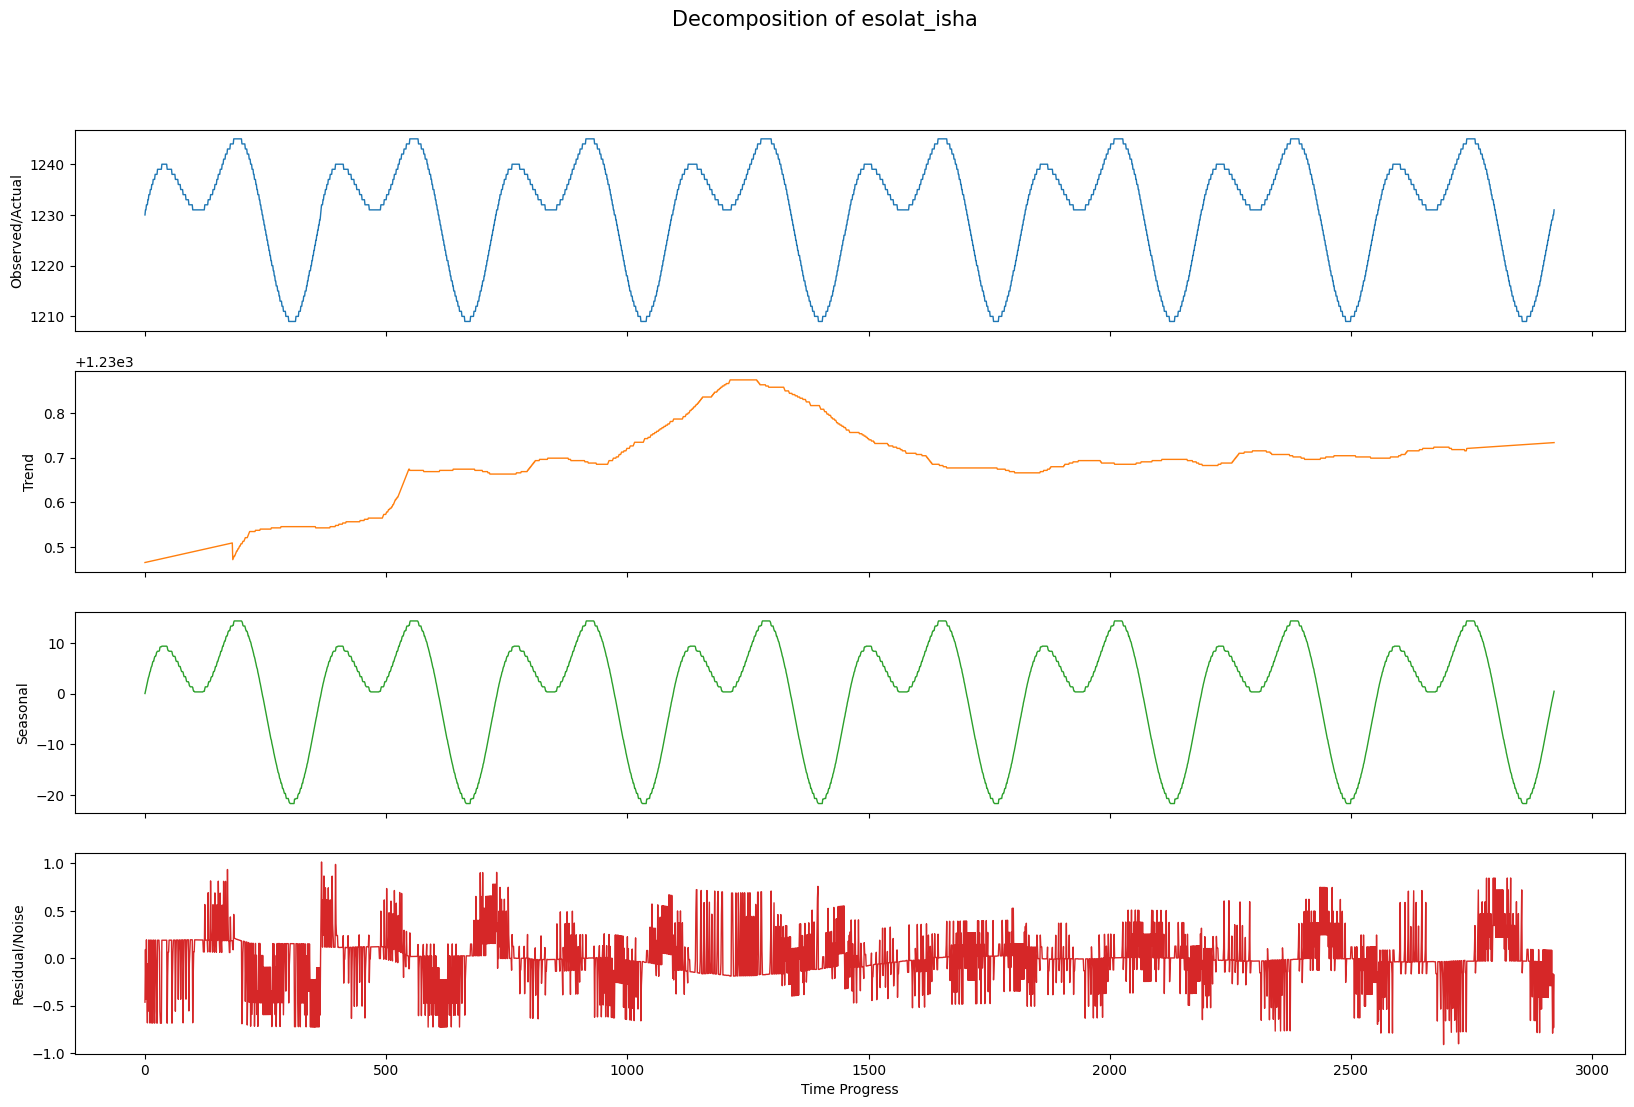

In [13]:
decompose_time_series_charts("esolat_isha")

<h2>Augmented Dickey-Fuller (ADF)</h2>
ADF is used to determine differencing parameter, d for ARIMA model

In [14]:
from statsmodels.tsa.stattools import adfuller as ADF

In [15]:
# First, check if time series is stationary or not
# H0: Time series is not stationary
# HA: Time series is stationary

def adf_test_plot(col_name=""):
    if col_name not in esolatDF.columns:
        return

    f, ax = plt.subplots(figsize=(12,5))

    result = ADF(esolatDF[col_name])
    conf_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_1 = result[4]["1%"]
    crit_5 = result[4]["5%"]
    crit_10 = result[4]["10%"]

    if (p_val < conf_level) & (adf_stat < crit_1):
        linecolor = "C2"
    elif (p_val < conf_level) & (adf_stat < crit_5):
        linecolor = "gold"
    elif (p_val < conf_level) & (adf_stat < crit_10):
        linecolor = "C1"
    else:
        linecolor = "C3"
    
    sns.lineplot(data=esolatDF, x="date", y=col_name, ax=ax, color=linecolor, linewidth=1)
    plt.title(
        f"ADF Statistic = {adf_stat:0.3f}\
        p-value = {p_val:0.3f}\
        \nCritical Values: 1% = {crit_1:0.3f}\
        5% = {crit_5:0.3f}\
        10% = {crit_10:0.3f}"
    )
    plt.show()

    p_test = bool(p_val < conf_level)
    adf_test_1 = bool(adf_stat < crit_1)
    adf_test_5 = bool(adf_stat < crit_5)
    adf_test_10 = bool(adf_stat < crit_10)

    print("=== Summary on Augmeneted Dickey-Fueller (ADF) Test ===")
    print("p-value < 0.05 : ", p_test)
    if p_test == True:
        print("H0 is REJECTED. Time series data is stationary.")
    else:
        print("Failed to reject H0. Time series data might not be stationary.")
    print()
    print("ADF Statistic < Critical Values")
    print("1% : ", adf_test_1)
    print("5% : ", adf_test_5)
    print("10% : ", adf_test_10)
    if (adf_test_1 == True) & (adf_test_5 == True) & (adf_test_10 == True):
        print("H0 is REJECTED. Time series data is stationary.")
    else:
        print("Failed to reject H0. Time series data might not be stationary.")
    print("=======================================================")

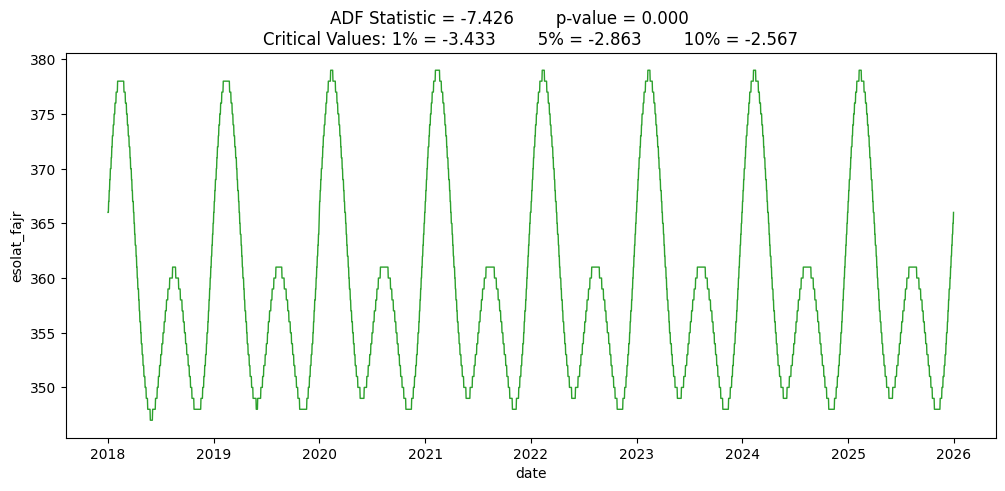

=== Summary on Augmeneted Dickey-Fueller (ADF) Test ===
p-value < 0.05 :  True
H0 is REJECTED. Time series data is stationary.

ADF Statistic < Critical Values
1% :  True
5% :  True
10% :  True
H0 is REJECTED. Time series data is stationary.


In [16]:
adf_test_plot("esolat_fajr")

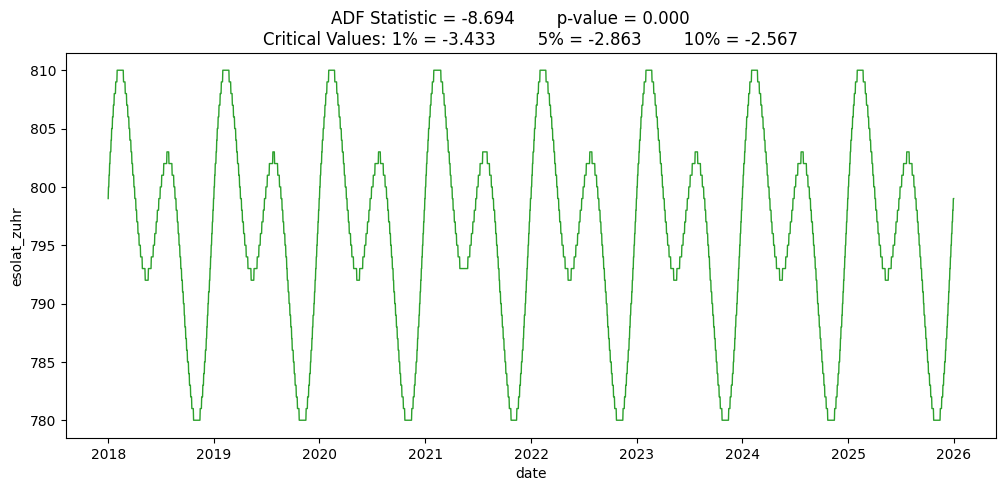

=== Summary on Augmeneted Dickey-Fueller (ADF) Test ===
p-value < 0.05 :  True
H0 is REJECTED. Time series data is stationary.

ADF Statistic < Critical Values
1% :  True
5% :  True
10% :  True
H0 is REJECTED. Time series data is stationary.


In [17]:
adf_test_plot("esolat_zuhr")

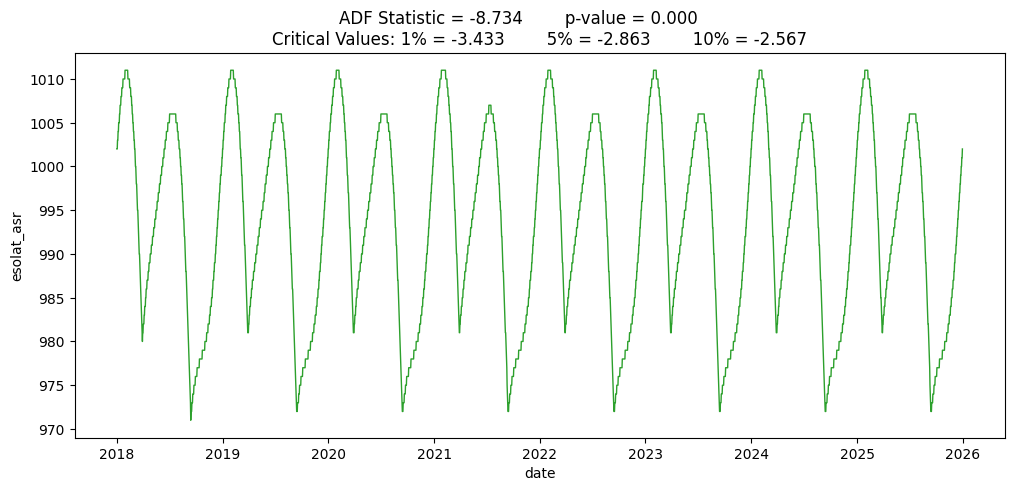

=== Summary on Augmeneted Dickey-Fueller (ADF) Test ===
p-value < 0.05 :  True
H0 is REJECTED. Time series data is stationary.

ADF Statistic < Critical Values
1% :  True
5% :  True
10% :  True
H0 is REJECTED. Time series data is stationary.


In [18]:
adf_test_plot("esolat_asr")

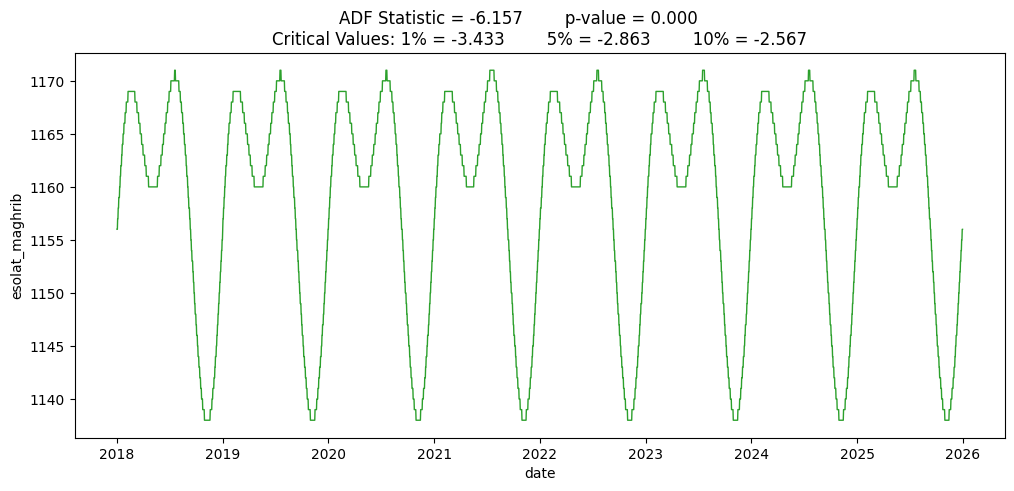

=== Summary on Augmeneted Dickey-Fueller (ADF) Test ===
p-value < 0.05 :  True
H0 is REJECTED. Time series data is stationary.

ADF Statistic < Critical Values
1% :  True
5% :  True
10% :  True
H0 is REJECTED. Time series data is stationary.


In [19]:
adf_test_plot("esolat_maghrib")

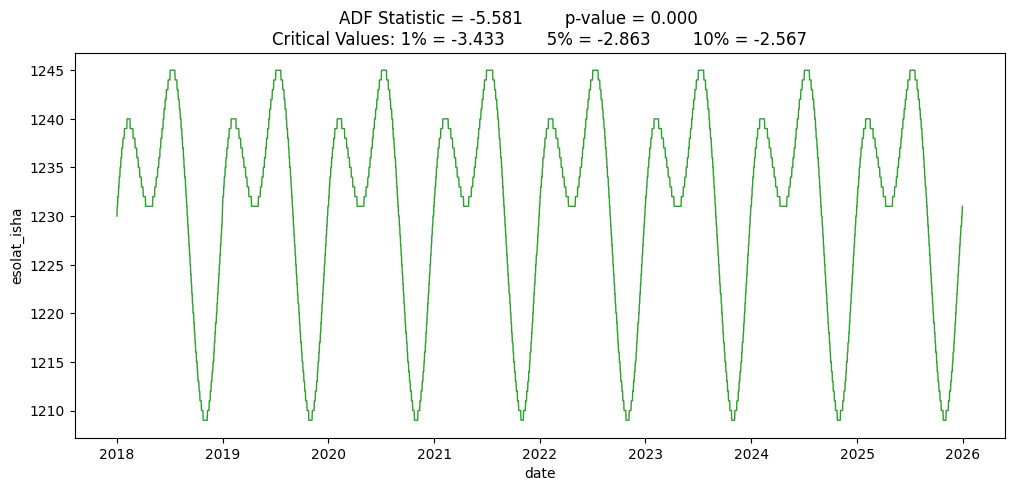

=== Summary on Augmeneted Dickey-Fueller (ADF) Test ===
p-value < 0.05 :  True
H0 is REJECTED. Time series data is stationary.

ADF Statistic < Critical Values
1% :  True
5% :  True
10% :  True
H0 is REJECTED. Time series data is stationary.


In [20]:
adf_test_plot("esolat_isha")

In [21]:
# Determine degree of differencing, d based on order of differencing
# e.g. if 1st order differencing already gives stationary, then d = 1
# differencing must be based on period of seasonality e.g. monthly, period = 12; daily = period = 365

def differencing_time_series(col_name=""):
    if col_name not in esolatDF.columns:
        return
    
    sd_0 = np.std(esolatDF[col_name])

    ts_diff_1 = np.diff(esolatDF[col_name], 365)
    ts_diff_1 = np.append(0, ts_diff_1)
    sd_1 = np.std(ts_diff_1)

    ts_diff_2 = np.diff(ts_diff_1, 365)
    ts_diff_2 = np.append(0, ts_diff_2)
    sd_2 = np.std(ts_diff_2)

    ts_diff_3 = np.diff(ts_diff_2, 365)
    ts_diff_3 = np.append(0, ts_diff_3)
    sd_3 = np.std(ts_diff_3)

    results = {"diff_order": [0, 1, 2, 3], "std_dev": [sd_0, sd_1, sd_2, sd_3]}
    df = pd.DataFrame.from_dict(results)
    print(df.sort_values(by="std_dev", ascending=True))
    print("======================================")
    print("Note: Lowest std_dev = Best diff_order")

In [22]:
differencing_time_series("esolat_fajr")

   diff_order       std_dev
0           0  9.513236e+00
2           2  5.292398e+18
1           1  5.308995e+18
3           3  5.371052e+18
Note: Lowest std_dev = Best diff_order


In [23]:
differencing_time_series("esolat_zuhr")

   diff_order       std_dev
0           0  8.724700e+00
3           3  5.286941e+18
2           2  5.289823e+18
1           1  5.314149e+18
Note: Lowest std_dev = Best diff_order


In [24]:
differencing_time_series("esolat_asr")

   diff_order       std_dev
0           0  1.118565e+01
2           2  5.278346e+18
1           1  5.293705e+18
3           3  5.333682e+18
Note: Lowest std_dev = Best diff_order


In [25]:
differencing_time_series("esolat_maghrib")

   diff_order       std_dev
0           0  1.029735e+01
3           3  5.290230e+18
1           1  5.298184e+18
2           2  5.336754e+18
Note: Lowest std_dev = Best diff_order


In [26]:
differencing_time_series("esolat_isha")

   diff_order       std_dev
0           0  1.078140e+01
1           1  5.294399e+18
2           2  5.299510e+18
3           3  5.310654e+18
Note: Lowest std_dev = Best diff_order


<h2>Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) Plots</h2>
<ul>
    <li>ACF plot to determine coefficient of lag for Moving Average, q</li>
    <li>PACF plot to determine coefficient of lag for Auto-Regressive, p</li>
</ul>
<br/>
Both p and q are used in ARIMA model

In [27]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [28]:
def acf_pacf_plots(col=[], name=""):
    if len(col) == 0:
        return

    f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16,12))
    f.suptitle(f"ACF and PACF plots for {name}", fontsize=15, y=0.93)
    plot_acf(col, lags=100, ax=ax[0])
    plot_pacf(col, lags=100, ax=ax[1])
    ax[0].set_xlabel("Lags")
    ax[1].set_xlabel("Lags")
    plt.show()

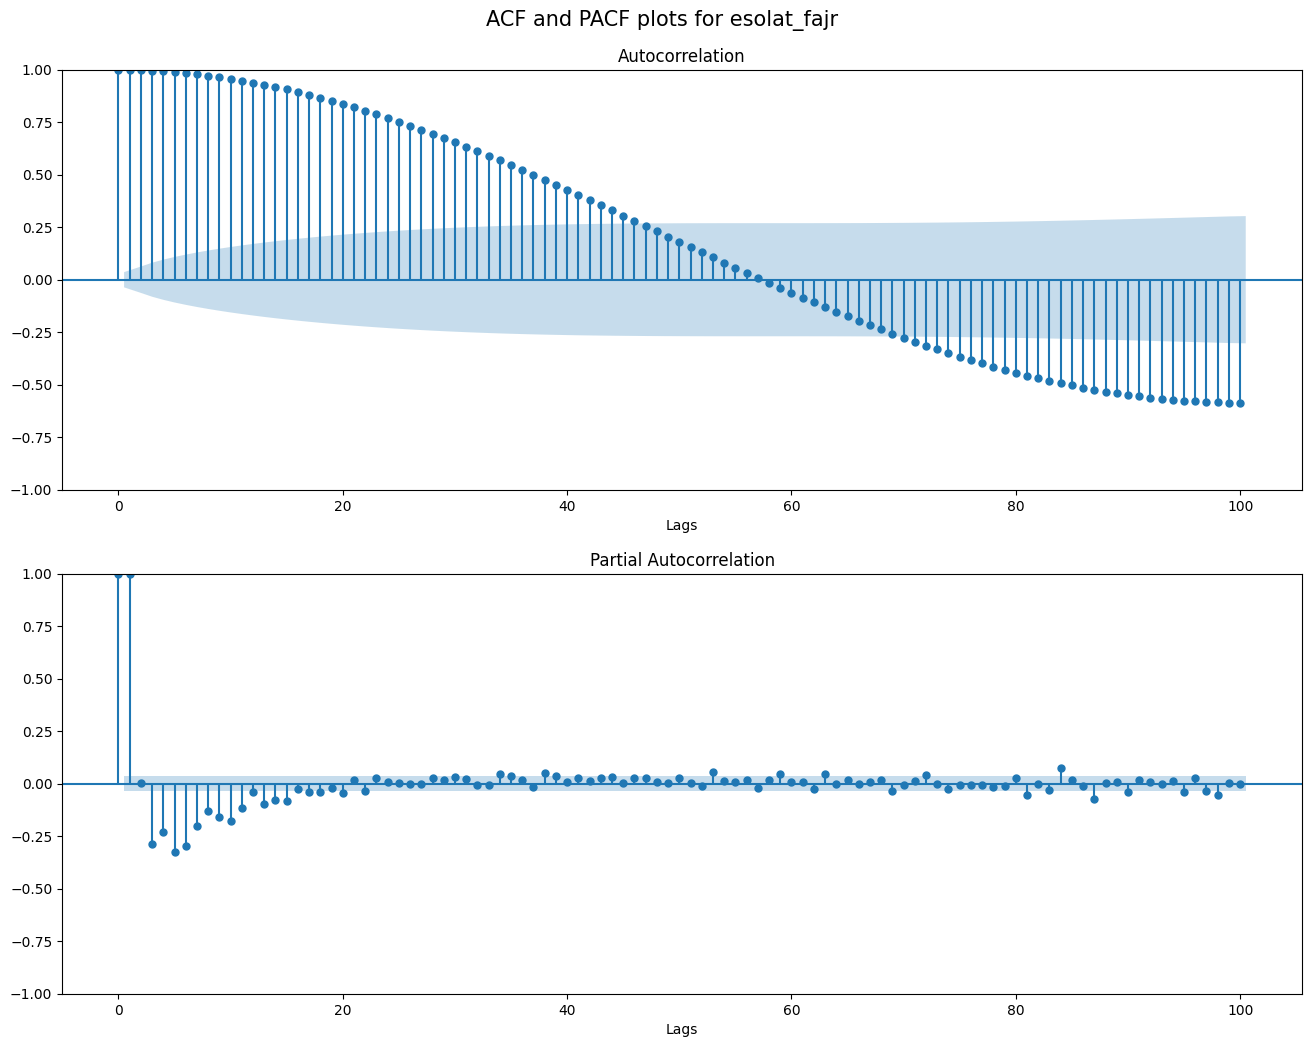

In [29]:
acf_pacf_plots(esolatDF["esolat_fajr"], "esolat_fajr")

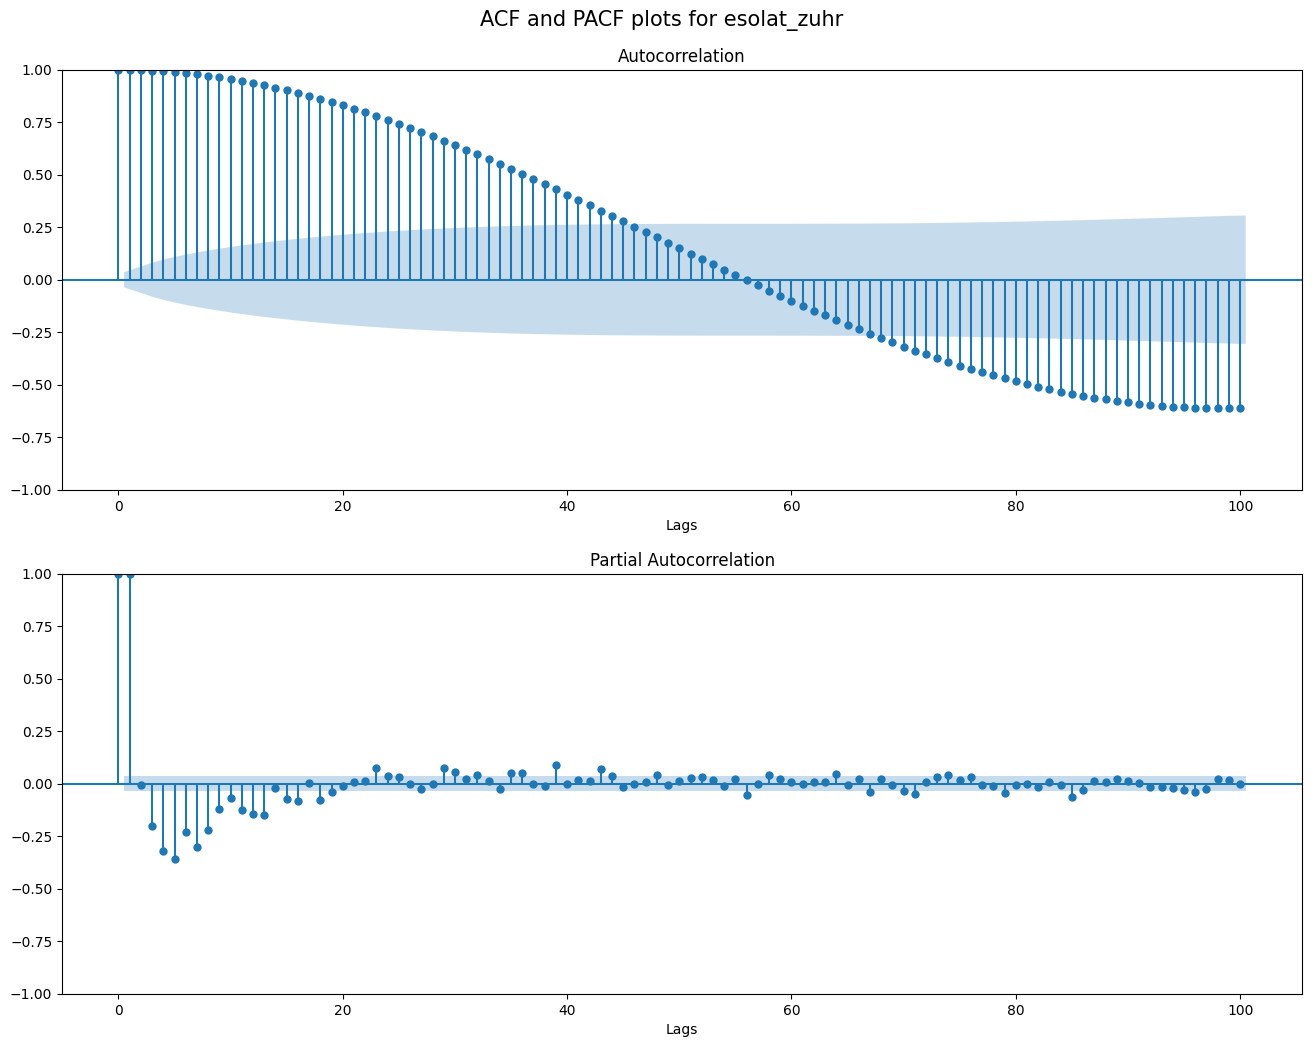

In [30]:
acf_pacf_plots(esolatDF["esolat_zuhr"], "esolat_zuhr")

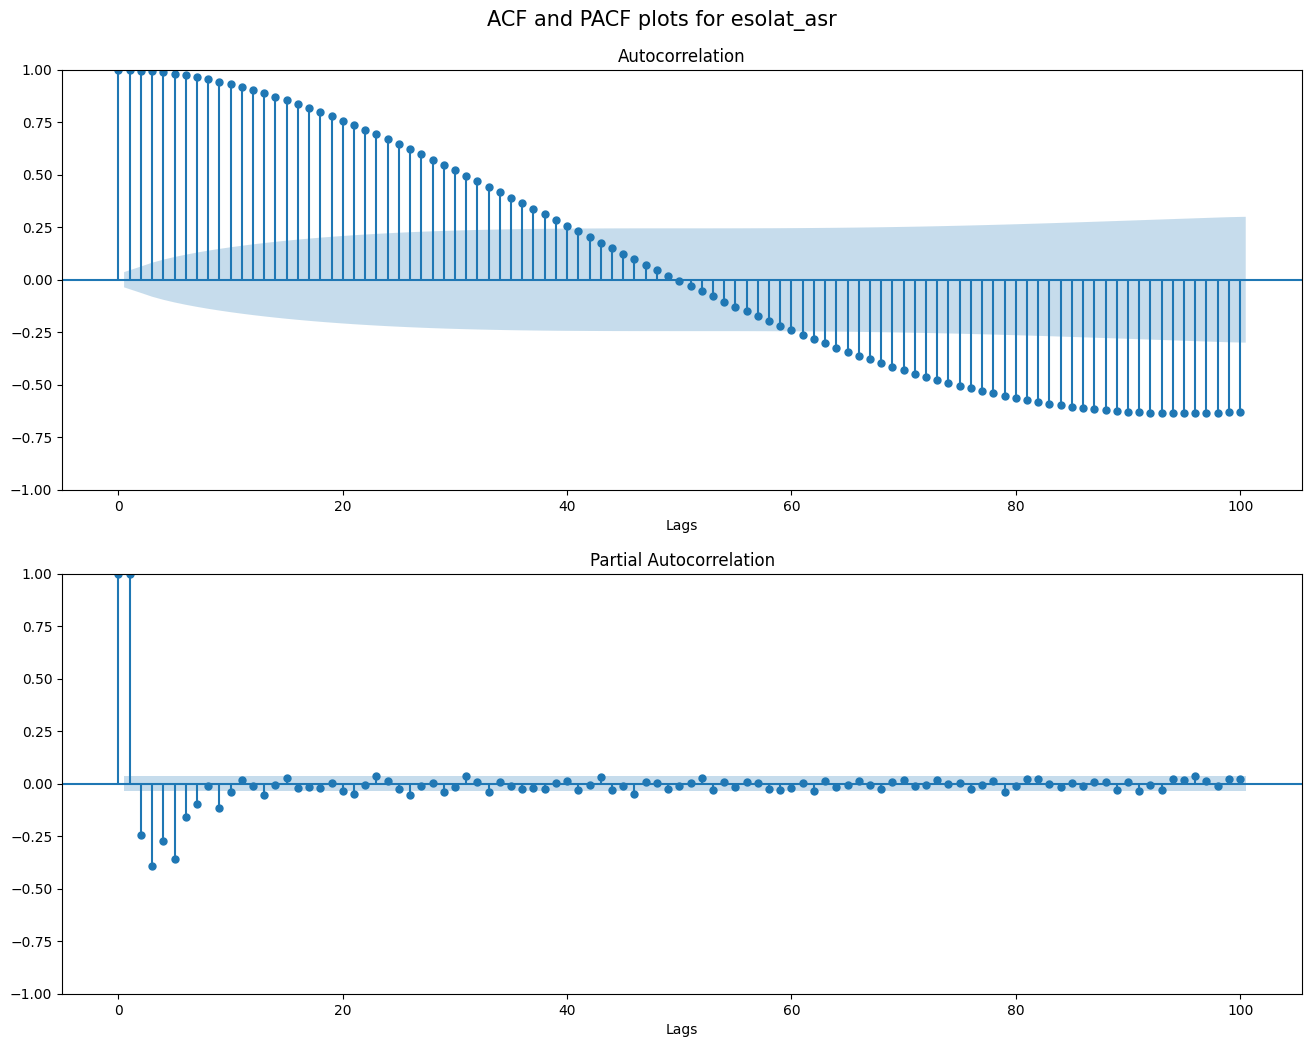

In [31]:
acf_pacf_plots(esolatDF["esolat_asr"], "esolat_asr")

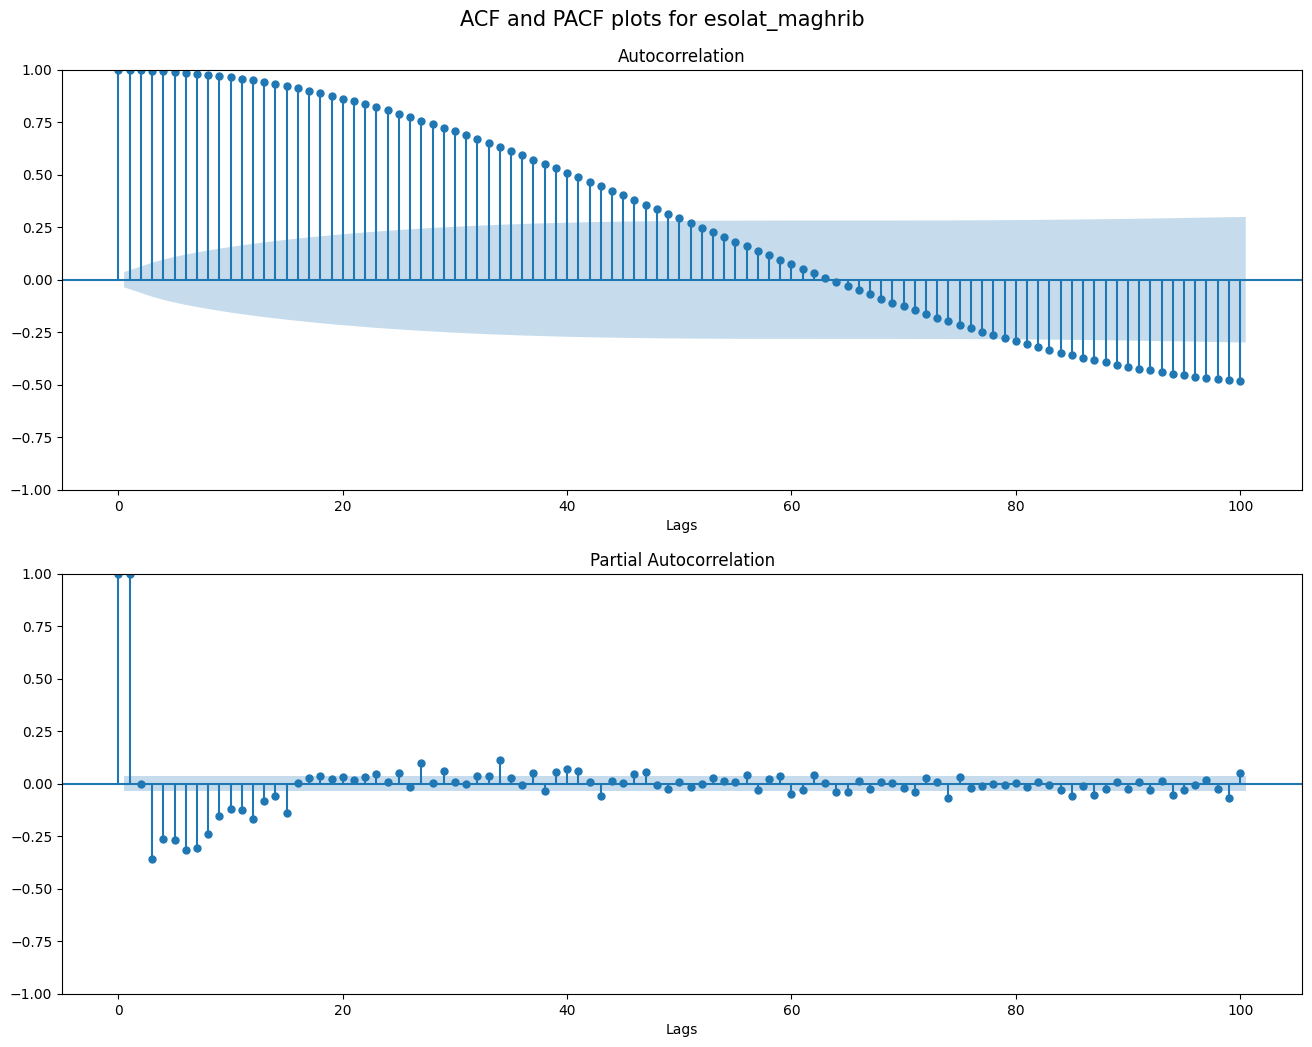

In [32]:
acf_pacf_plots(esolatDF["esolat_maghrib"], "esolat_maghrib")

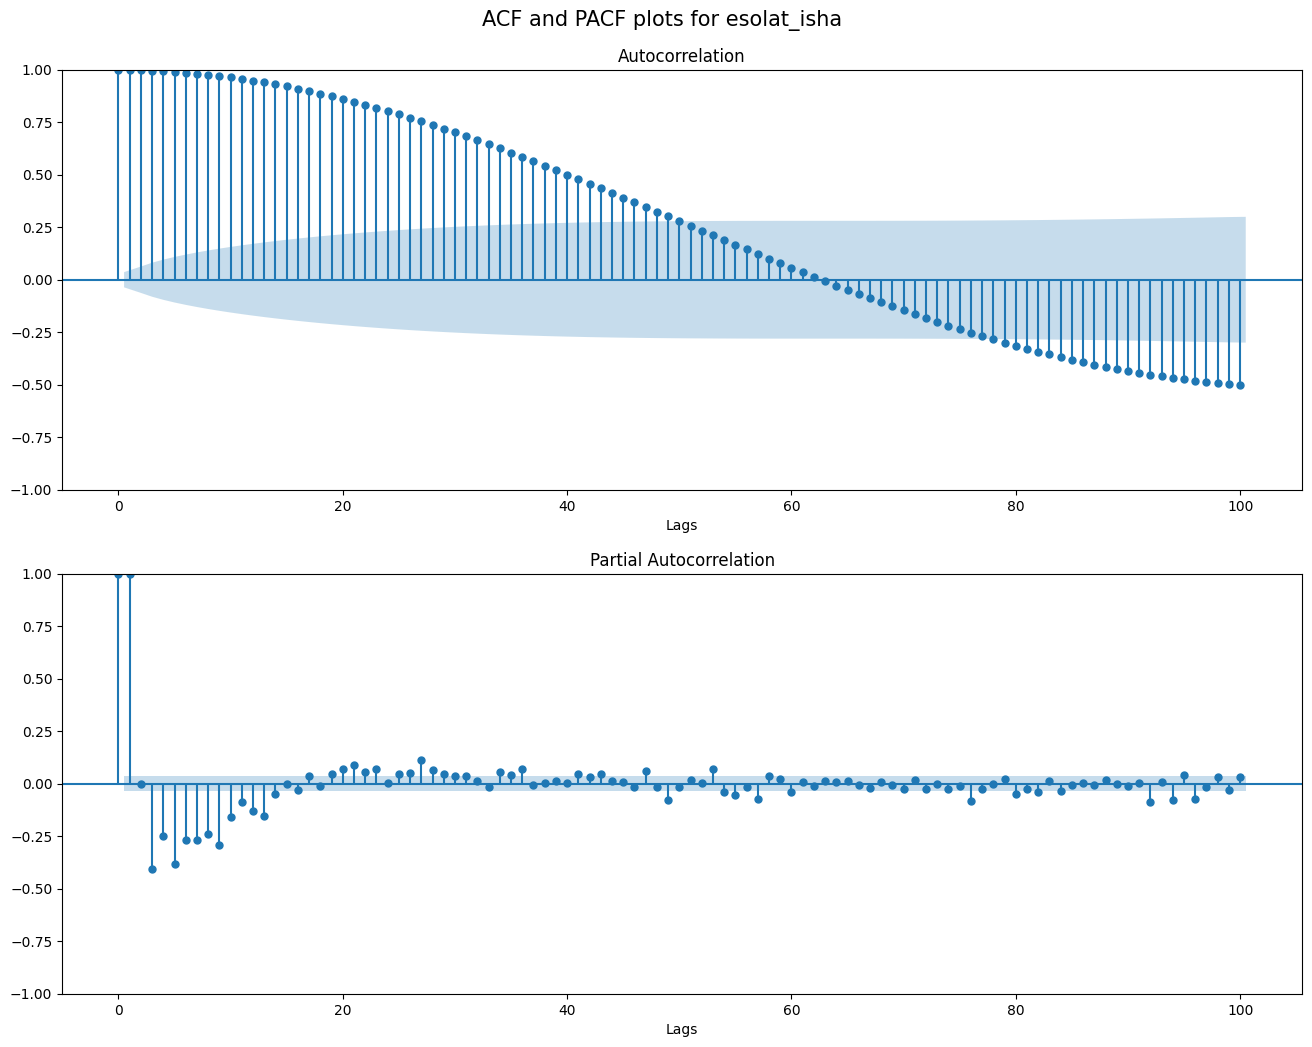

In [33]:
acf_pacf_plots(esolatDF["esolat_isha"], "esolat_isha")

<ul>
    <li>ACF showing patterns of noises after 44th lag. While q might be equal to 44, usually ARMIA model with large q produces overfitting model. Hence, a range between 0 to 9 will be further determined for q.</li>
    <li>PACF showing patterns of noises after 1st lag. Thus, p = 1.</li>
<ul>

In [34]:
def diff_1st_order(col_name="", period=""):
    if col_name not in esolatDF.columns:
        return []
    
    periods = {"day": 365, "week": 52, "month": 12, "quarter": 4, "semi": 2}
    if period not in periods:
        return []

    first_diff = np.diff(esolatDF[col_name], n=periods[period])
    return np.append(0, first_diff)

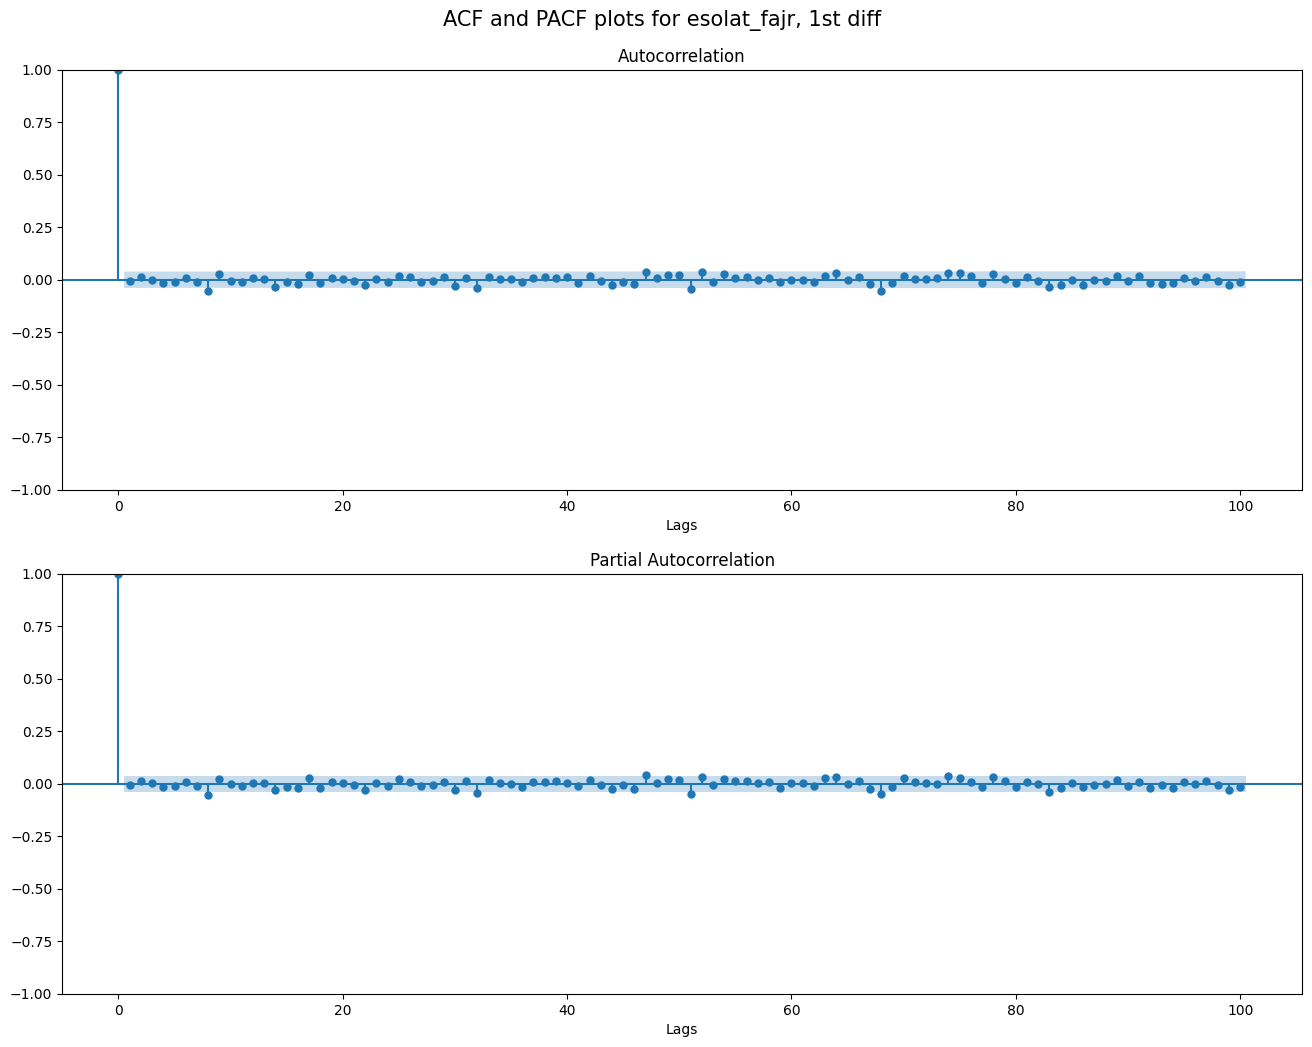

In [35]:
acf_pacf_plots(diff_1st_order("esolat_fajr", "day"), "esolat_fajr, 1st diff")

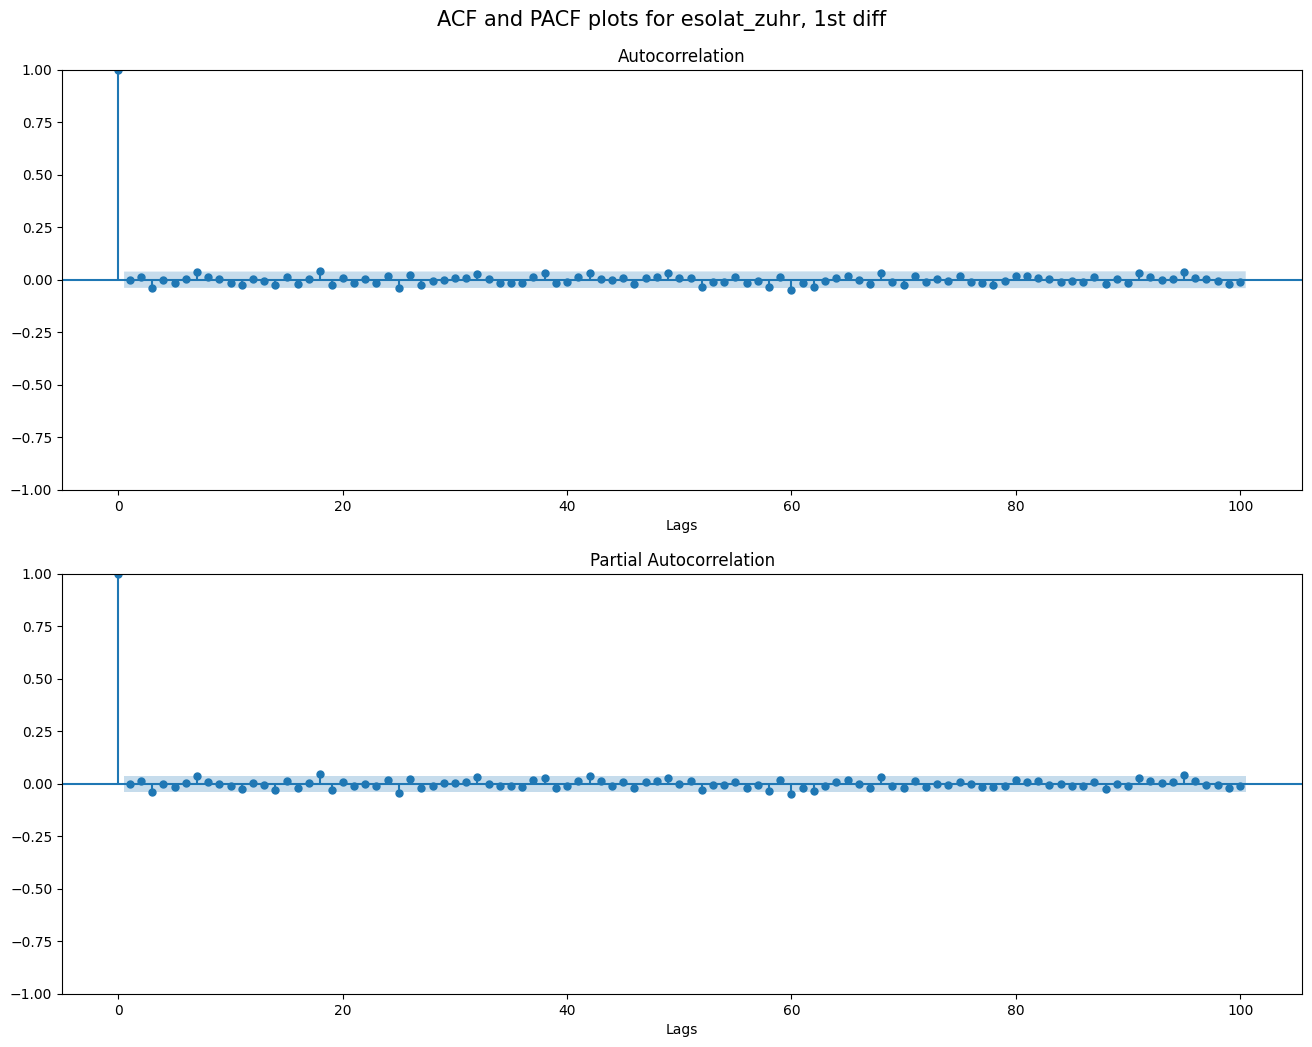

In [36]:
acf_pacf_plots(diff_1st_order("esolat_zuhr", "day"), "esolat_zuhr, 1st diff")

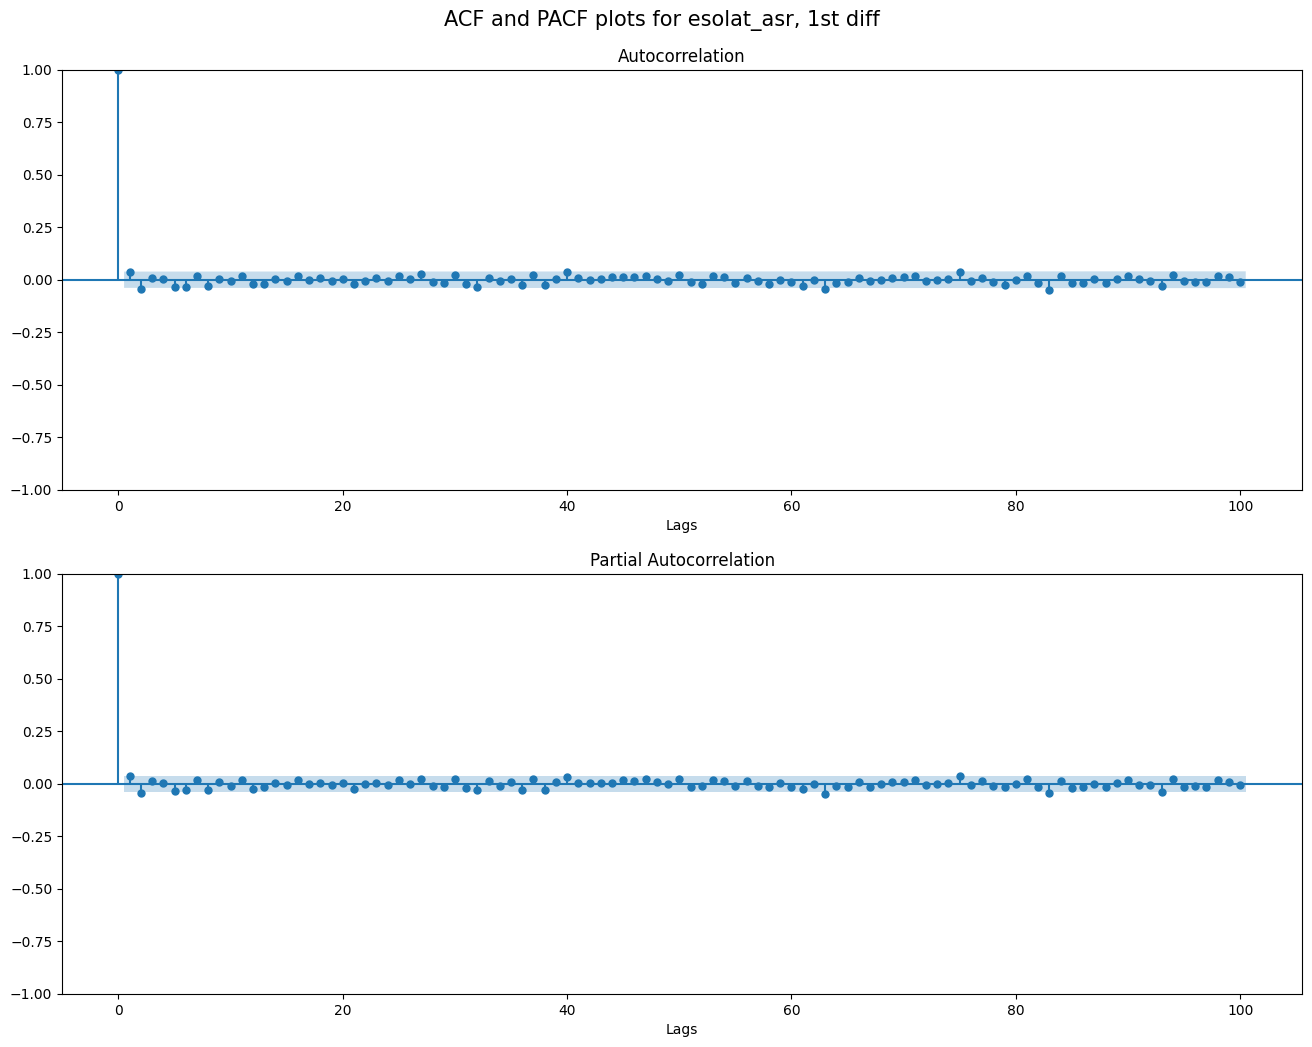

In [37]:
acf_pacf_plots(diff_1st_order("esolat_asr", "day"), "esolat_asr, 1st diff")

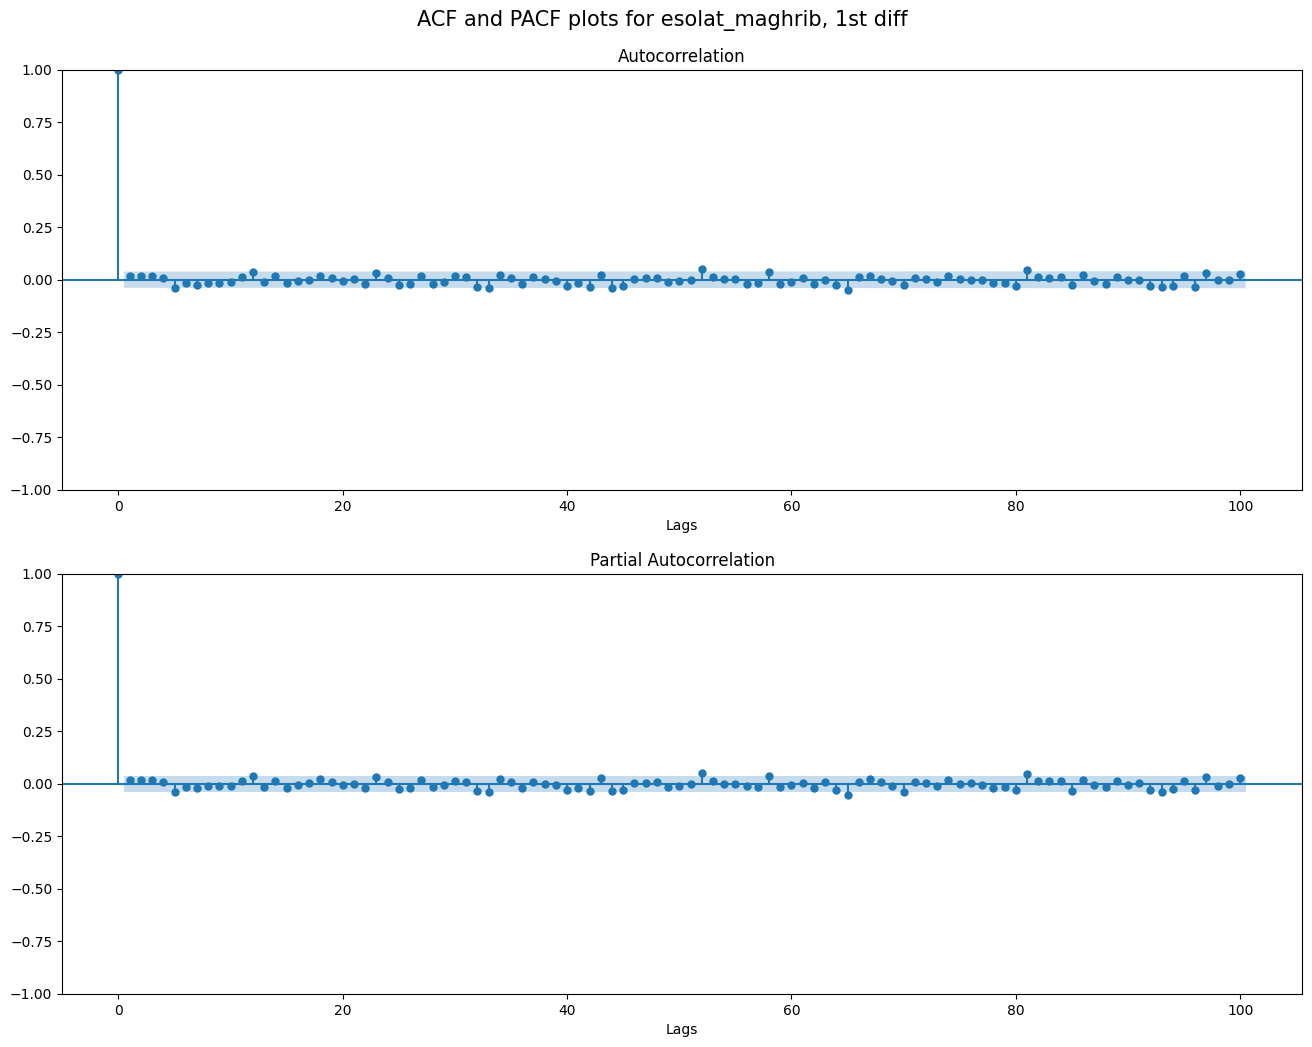

In [38]:
acf_pacf_plots(diff_1st_order("esolat_maghrib", "day"), "esolat_maghrib, 1st diff")

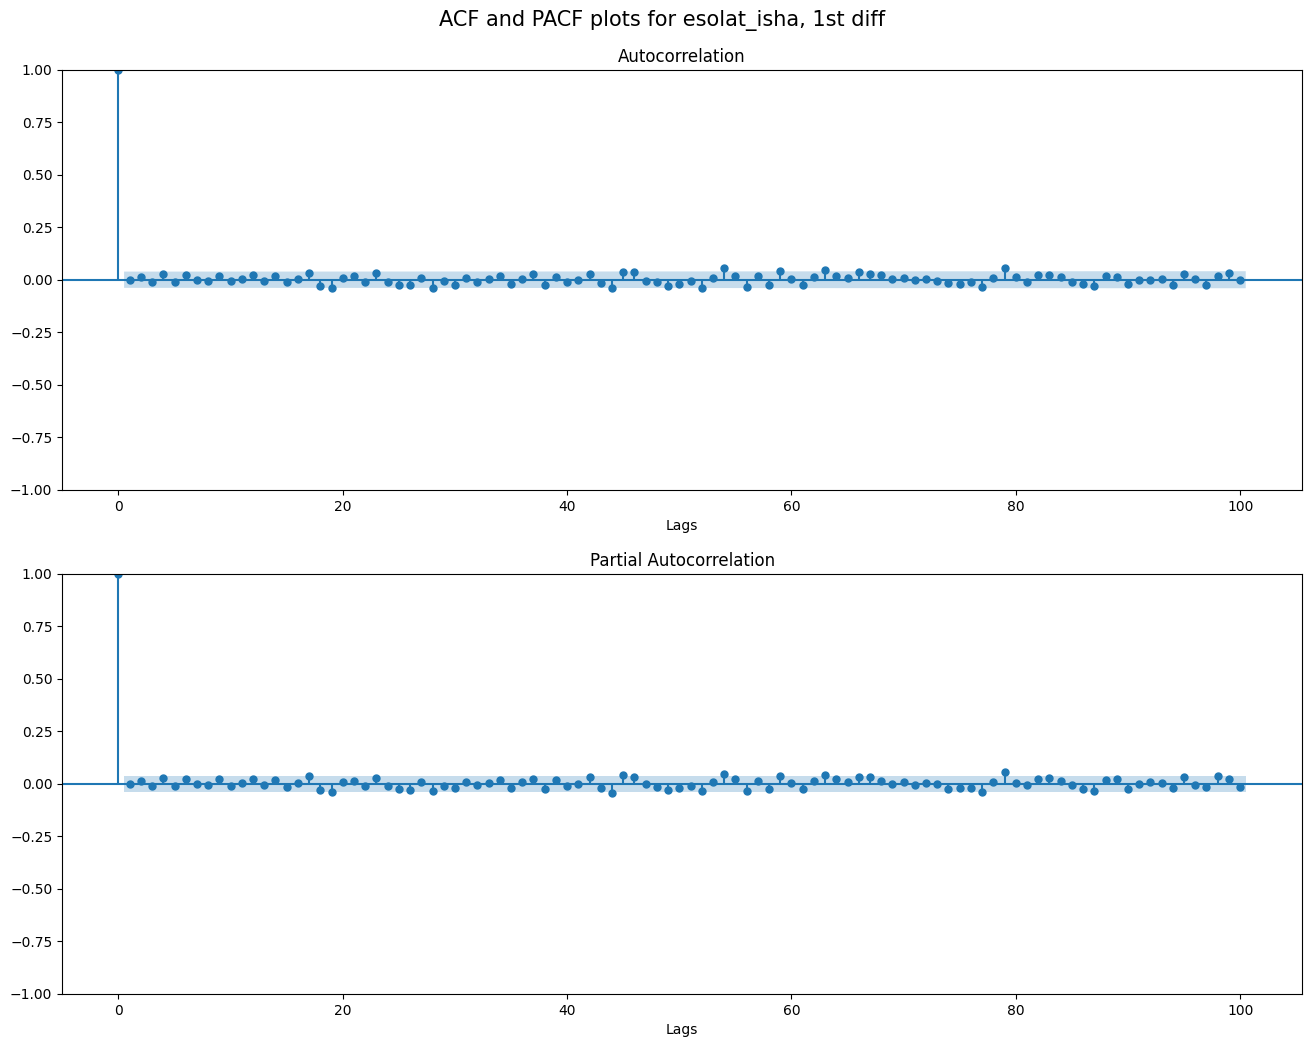

In [39]:
acf_pacf_plots(diff_1st_order("esolat_isha", "day"), "esolat_isha, 1st diff")

After 1st order of differencing,<br/>
<ul>
    <li>ACF showing patterns of noises starting 1st lag. Hence, q = 0</li>
    <li>PACF showing patterns of noises starting 1st lag. Hence, p = 0</li>
</ul>